# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|
|xgboost|0.8|

**강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com)**

In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend # 오류 발생시!!!: !pip install --upgrade mlxtend 
import sys
import xgboost as xgb # 오류 발생시!!!: !pip install --upgrade xgboost 

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, xgb]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
xgboost 0.80


In [2]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요

다음은 폴더블 폰의 힌지에 들어가는 스프링 내구력을 테스트한 실험 결과이다. 

스프링 측정값과 스프링에 가한 부하 정보와 함께, 테스트 통과/실패 (failure) 결과가 기재되어 있다. 

개발부서는 테스트 비용을 줄이기 위해 failure 여부를 맞추는 모델을 만들고자 한다.

변수명은 보안을 위해 measurement_0과 같이 익명화되었다.

데이터 구성

학습데이터: train_prob.csv, 21,458 rows, 25 columns

테스트데이터: test_prob.csv, 5,112 rows, 24 columns, 

테스트정답셋: test_prob_ans.csv, 5,112 rows, 1 columns


컬럼명	설명	타입

|변수명|설명|타입|
|--|--------------|------|
|id|실험 고유 번호|정수형|
|product_code|스프링 코드|범주형|
|loading|스프링에 가한 부하|실수형|
|attribute_0|구성 소재1|범주형|
|attribute_1|구성 소재2|범주형|
|attribute_2|구성 소재3|정수형|
|attribute_3|구성 소재4|정수형|
|measurement_0 ~ 17|측정값 0~17|실수형|
|failure|성공여부|이진형(0, 1)|


# 전처리(Preprocessing)

train_prob.csv를 불러 온다. 이를 basetable이라고 한다.

In [3]:
# 데이터를 식별할 수 있는(유일성이 있는) 컬럼은 인덱스로 쓸만합니다.  index_col = 'id'
df_basetable = pd.read_csv('train_prob.csv', index_col = 'id')
display(df_basetable.head())
df_basetable.info()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21458 entries, 0 to 26569
Data columns (total 25 columns):
product_code      21458 non-null object
loading           21257 non-null float64
attribute_0       21458 non-null object
attribute_1       21458 non-null object
attribute_2       21458 non-null int64
attribute_3       21458 non-null int64
measurement_0     21458 non-null int64
measurement_1     21458 non-null int64
measurement_2     21458 non-null int64
measurement_3     21146 non-null float64
measurement_4     21016 non-null float64
measurement_5     20893 non-null float64
measurement_6     20818 non-null float64
measurement_7     20692 non-null float64
measurement_8     20605 non-null float64
measurement_9     20469 non-null float64
measurement_10    20399 non-null float64
measurement_11    20278 non-null float64
measurement_12    20171 non-null float64
measurement_13    20063 non-null float64
measurement_14    19976 non-null float64
measurement_15    19855 non-null float64
me

# 단계 1

basetable에 measurement_3 ~17 각각의 행이 결측인지 나타내는 파생 변수를 만든다. 

파생 변수는 이진 형식이고, False는 미결측 True는 결측을 의미한다. 

파생 변수의 이름은 measurement 번호에 따라 isna_3 ~ 17로 한다. 

In [4]:
# 둘 다 인덱스를 기준으로 결합을 하면 되므로 join을 사용합니다.
df_basetable = df_basetable.join(
    df_basetable[['measurement_{}'.format(i) for i in range(3, 18)]].isna().rename(
        columns = lambda x: x.replace('measurement', 'isna') # rename(columns = 함수) 함수에는 컬럼명이 전달이 되고 바꾸고자 하는 컬럼명을 반환하면됩니다.
    )
)
df_basetable.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_8,isna_9,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,False,False,False,True,False,False,False
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,False
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,False,False,False,True,False,False,False,False,False,False
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,False
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,False


## 단계 2

이 과제를 맡은 데이터분석가 지희는 measurement_3~17의 결측치 처리 방안을 고민하던 중, 

개발부서에서 measurement_17은 product_code별로 failure를 예측하기 위해 

measurement_3 ~ measurement_9을 다음과 같이 선형 조합하여 생성한 값이라는 정보를 받았다. 

$measurement_{17}= \beta_{0} + \beta_{3}measurement_{3}+\beta_{4}measurement_{4}+...+\beta_{9}measurement_{9}$

이는 즉,

$measurement_{3}= \beta'_{0} + \beta'_{4}measurement_{4}+\beta'_{5}measurement_{5}+...+\beta'_{9}measurement_{9} + \beta'_{17}measurement_{17}$

...

$measurement_{9}= \beta''_{0} + \beta''_{3}measurement_{3}+\beta''_{4}measurement_{4}+...+\beta''_{8}measurement_{8}+\beta''_{17}measurement_{17}$

와 같이 measurement_3 ~ measurement_9의 각 변수들도 나머지 변수들과 선형 관계를 지닌다. 

이 점을 이용하여 대상 변수를 번갈아 가면서 예측 모델을 만들어 최대한 원래 값에 가깝게 복원할 수 있다. 

이러한 반복적인 결측치 복원 방법을 사내 데이터분석 연구소에 문의 했더니 다음과 같은 가이드를 주었다. 

> sklearn 모듈에 아직은 실험 단계이지만, 비슷한 경우에 문제 없이 사용했던 사례가 있어 의견을 드립니다. 

> from sklearn.experimental import enable_iterative_imputer 구문을 사용하여 실험 단계인 모듈을 활성화하고, 

> sklearn.impute.IterativeImputer를 사용한다면 원하는 결과를 얻을 수 있습니다.

가이드의 내용를 참조하여 product_code에 따른 measurement3-9, measurement17의 선형 관계를 이용하여, 

basetable의 measurement_3~9와 measurement_17 결측치를 복원하라.


입력 변수] measurement_3 ~ 9, measurement_17 (입력 변수 순서에 유의)

---
**함수가이드**

sklearn.experimental.enable_iterative_imputer

sklearn.impute.IterativeImputer, random_state=123

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [5]:
# 방법1: 반복문
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
# product_code에 따른 measurement3-9, measurement17의 선형 관계를 이용

# basetable의 measurement_3~9와 measurement_17 결측치를 복원
# 입력: measurement_3 ~ 9, measurement_17
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
imp = IterativeImputer(
    estimator = LinearRegression(fit_intercept = True), 
    random_state=123
)
for i in df_basetable['product_code'].unique():
    # product_code가 i에 해당하는 데이터를 가져오기 위한 boolean index를 만듭니다.
    s_bidx = df_basetable['product_code'] == i
    # df_basetable.loc[s_id][X_imp] = imp.fit_transform(df_basetable.loc[s_idx, X_imp]) 는 SettingWithCopyWarning이 발생하니 사용하면 안 됩니다.
    df_basetable.loc[s_bidx, X_imp] = imp.fit_transform(df_basetable.loc[s_bidx, X_imp])

In [6]:
# 방법 2: groupby ~ apply ~ fit_transform
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
# product_code에 따른 measurement3-9, measurement17의 선형 관계를 이용

# basetable의 measurement_3~9와 measurement_17 결측치를 복원
# 입력: measurement_3 ~ 9, measurement_17
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
imp = IterativeImputer(
    estimator = LinearRegression(fit_intercept = True), 
    random_state=123
)
# apply에서 imp가 transform 해서 준 타입이 2차원 numpy array입니다.
# 이는 groupby ~ apply 에서 처리를 못해줍니다.
# 2차원 numpy array를 DataFrame으로 만들어주면
# apply에서 DataFrame으로 재구성하여 넘겨줍니다.
# 모델을 적용하여 결측이 처리된 데이터프레임을 만듭니다.
df_basetable[X_imp] = df_basetable.groupby('product_code')[X_imp].apply(
    lambda x: pd.DataFrame(imp.fit_transform(x), index = x.index, columns = x.columns)
)

In [7]:
# 방법 3: groupby ~ apply ~ fit , gropupby ~ apply ~ transform
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
# product_code에 따른 measurement3-9, measurement17의 선형 관계를 이용

# basetable의 measurement_3~9와 measurement_17 결측치를 복원
# 입력: measurement_3 ~ 9, measurement_17
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
def create_imp():
    return IterativeImputer(
        estimator = LinearRegression(fit_intercept = True), 
        random_state=123
    )
s_imp = df_basetable.groupby('product_code')[X_imp].apply(
    lambda x: create_imp().fit(x) # 각각의 경우에 대한 모델을 지녀야 하므로 Imputer 인스턴스를 생성시킵니다.
)
# x.name통해 적용한 imputer를 가져와서 transform합니다.
df_basetable[X_imp] = df_basetable.groupby('product_code')[X_imp].apply(
    lambda x: pd.DataFrame(s_imp[x.name].transform(x), index = x.index, columns = x.columns)
)

## 단계 3

measurement_10~16까지의 결측치는 모두 product_code별 평균으로 대치한다.

In [8]:
# 방법1: groupby ~ transform
X_mean = ['measurement_{}'.format(i) for i in range(10, 17)]
df_basetable[X_mean] = df_basetable.groupby('product_code')[X_mean].transform(
    lambda x: x.fillna(x.mean())
)

In [9]:
# 방법2: groupby ~ apply
df_basetable[X_mean] = df_basetable.groupby('product_code')[X_mean].apply(
    lambda x: x.fillna(x.mean())
).reset_index(level = 0, drop = True) # 인덱스에 붙은 product_code를 제거시켜 대입이 되도록 합니다.

Hint] 전처리 단계에서 보간 결과를 확인해 보기 위한 각 변수의 평균과 표본표준편차.

| |3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|
|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|
|mean|17.796|11.736|17.131|17.506|11.719|19.022|11.434|16.034|19.194|11.734|15.666|16.033|15.051|16.398|701.768|
|std|0.997|0.994|0.994|0.992|0.993|1.005|0.997|1.278|1.579|1.433|1.149|1.461|1.478|1.671|119.180|

열의 이름의 숫자는 measurement_ 번호, 값은 소수점 3째 자리까지 반올림

In [10]:
df_basetable[['measurement_{}'.format(i) for i in range(3, 18)]].agg(
    ['mean', 'std']
).round(3).rename(
    columns = lambda x: x.split('_')[1]
)

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean,17.796,11.736,17.131,17.506,11.719,19.022,11.434,16.034,19.194,11.734,15.666,16.033,15.051,16.398,701.768
std,0.997,0.994,0.994,0.992,0.993,1.005,0.997,1.278,1.579,1.433,1.149,1.461,1.478,1.671,119.180


**Tip! product_code 별로 선형모델의 회귀 계수 / 절편 / R2 구해보기**

1. measurement_3~9와 measurement_17 에서 하나도 결측이 없는 레코드를 뽑아 df_tip 이라는 데이터프레임을 만듭니다. 


2. product_code별로 measurement_3 ~ 9를 입력 변수로 하여 measurement_17을 예측하는 절편이 있는 선형 회귀 모델을 만듭니다.


3. product_code별로 제작된 회귀 모델의 회귀 계수와 절편을 구해봅니다. 


4. product_code별로 제작된 선형회귀모델을 사용하여  measurement_17에 대한 예측값을  만들어 product_code 별로 R2 score를 구해봅니다.

In [11]:
# measurement_3~9와 measurement_17 에서 하나도 결측이 없는 레코드를 뽑아 df_tip 이라는 데이터프레임을 만듭니다.
df_tip = df_basetable.loc[
    ~df_basetable[['isna_{}'.format(i) for i in range(3, 10)] + ['isna_17']].any(axis = 1)
]
df_tip.isna().sum().rename('na_cnt').iloc[6:].to_frame().T

,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,...,isna_8,isna_9,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17
na_cnt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
from sklearn.linear_model import LinearRegression

# product_code별로 measurement_3 ~ 9를 입력 변수로 하여 measurement_17을 예측하는 절편이 있는 선형 회귀 모델을 만듭니다.
X_lr = ['measurement_{}'.format(i) for i in range(3, 10)]
s_lr = df_tip.groupby('product_code').apply(
    # 인스턴스를 남겨야 하므로 LinearRegression을 생성합고 fit을 시킵니다.
    lambda x: LinearRegression(fit_intercept = True).fit(x[X_lr], x['measurement_17'])
)
s_lr

product_code
A    LinearRegression(copy_X=True, fit_intercept=Tr...
B    LinearRegression(copy_X=True, fit_intercept=Tr...
C    LinearRegression(copy_X=True, fit_intercept=Tr...
E    LinearRegression(copy_X=True, fit_intercept=Tr...
dtype: object

In [13]:
from sklearn.metrics import r2_score
# product_code별로 제작된 회귀 모델의 회귀 계수와 절편을 구해봅니다.
# coef_, intercept_
# product_code별로 제작된 선형회귀모델을 사용하여 measurement_17에 대한 예측값을 만들어 product_code 별로 R2 score를 구해봅니다.
pd.concat([
    s_lr.apply(
        lambda x: pd.Series(x.coef_, index = X_lr) # 계수를 구합니다.
    ).rename(columns = lambda x: x.split('_')[1]),
    s_lr.apply(
        lambda x: x.intercept_ # 절편을 추출합니다.
    ).rename('intercept'),
    df_basetable.groupby('product_code').apply(
        lambda x: r2_score(x['measurement_17'], s_lr[x.name].predict(x[X_lr])) # product_code 별  r2_score 를 구합니다.
    ).rename('r2')
], axis = 1)

,3,4,5,6,7,8,9,intercept,r2
product_code,,,,,,,,,
A,-0.010131,14.878475,59.774801,26.726662,25.165509,77.357235,0.000678,-2732.327681,0.999982
B,18.526722,44.471955,34.970210,0.002739,87.464928,-0.004070,26.742221,-2079.732273,0.999983
C,0.014702,-0.005822,52.477022,7.175136,41.665531,91.211393,36.496277,-2964.440817,0.999986
E,0.015870,58.690919,66.624083,77.093626,-0.025606,73.145466,19.944851,-4097.927043,0.999990


**Tip!** 복합 데이터 처리 연습

1. train_prob.csv 를 불러와 df_myimp 데이터프레임을 만듭니다.


2. measurement_3 ~ 9, measurement_17 값에서 결측이 없는 데이터프레임 df_lr을 만듭니다.


3. measurement_3 ~ 9, measurement_17의 결측치를 다음 과정을 통해 처리합니다.

    (1) measurement_3 ~ 9, 17의 결측 여부를 df_na로 기록해둡니다.

    (2) measurement_3 ~ 9, 17의 결측치는 product_code 별 평균으로 대치합니다.

    (3) df_lr을 이용하여 product_code 별로 measurement_3~9, 17을 각각을 대상변수로 하고, 

     나머지 변수는 입력 변수인 선형회귀 모델을 만들어,
     
     결측이었던 변수(df_na가 True)인 변수들을 예측값으로 결측치를 대치합니다.

In [14]:
df_myimp = pd.read_csv('train_prob.csv', index_col = 'id')
df_myimp.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [15]:
# measurement_3 ~ 9, measurement_17 값에서 결측이 없는 데이터프레임 df_lr을 만듭니다.
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
df_lr = df_myimp[X_imp + ['product_code']].dropna() # Itempotent X
df_lr.head()

,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_17,product_code
id,,,,,,,,,
0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,764.100,A
1,18.213,11.540,17.717,17.893,12.748,17.889,12.448,682.057,A
2,18.057,11.652,16.738,18.240,12.718,18.288,12.715,663.376,A
3,17.295,11.188,18.576,18.339,12.583,19.060,12.471,826.282,A
4,19.346,12.950,16.990,15.746,11.306,18.093,10.337,579.885,A


In [16]:
# measurement_3 ~ 9, measurement_17의 결측치를 다음 과정을 통해 처리합니다.

# (1) measurement_3 ~ 9, 17의 결측 여부를 df_na로 기록해둡니다.
df_na = df_myimp[X_imp].isna() # Itempotent X
# (2) measurement_3 ~ 9, 17의 결측치는 product_code 별 평균으로 대치합니다.
df_myimp[X_imp] = df_myimp.groupby('product_code')[X_imp].transform(
    lambda x: x.fillna(x.mean())
) # product_code 별 평균으로 X_imp 변수들의 결측치를 채웁니다.

In [17]:
# (3) df_lr을 이용하여 product_code 별로 measurement_3~9, 17을 각각을 대상변수로 하고,
# 나머지 변수는 입력 변수인 선형회귀 모델을 만들어,
# 결측이었던 변수(df_na가 True)인 변수들을 예측값으로 결측치를 대치합니다.
from sklearn.linear_model import LinearRegression
for i in X_imp:
    X_lr = [j for j in X_imp if i != j]
    s_lr = df_lr.groupby('product_code')[X_imp].apply(
        lambda x: LinearRegression().fit(x[X_lr], x[i])
    ) # product_code 별로 대상변수가 i이고 입력 변수가 X_lr인 선형 회귀 모델을 만듭니다.
    df_tmp = df_myimp.loc[df_na[i]]
    df_myimp.loc[df_na[i], i] = df_tmp.groupby('product_code')[X_lr].apply(
        lambda x: pd.DataFrame(s_lr[x.name].predict(x), index = x.index, columns = [i])
    ) # product_code 별로 결측 변수의 예측값을 만들고 대입시켜줍니다.

# 문제1

(basetable을 사용) measurement_3~16까지 결측 여부가 failure에 영향이 있는지를 파악하고, 

failure를 분류하는 데 도움이 될 만한 것은 예측 모델의 입력 변수로 사용하고자 한다. 

이를 위해 전처리 과정에서 뽑아낸 isna_3~16을 활용한다.

n이 3부터 16까지, 즉 measurement_3~16까지 다음의 검정을 수행한다. 

$H_0: P(failure=True|measurement_{n}=Missing)=P(failure=True)$

$H_1: P(failure=True|measurement_{n}=Missing) \neq P(failure=True)$

모집단의 $P(failure=True) = 0.2114$


## 단계 1-1

우선, measurement_3으로 위 검정을 시행해보자.

$H_0: P(failure=True|isna_{3}=True)=0.2114$

$H_1: P(failure=True|isna_{3}=True) \neq 0.2114$

으로 바꿀 수 있다.

$P(failure=True|isna_{3}=True)$은 표본수가 충분하여 중심극한정리에 의해 정규분포를 따르는 것은 분석가 간에 이견이 없다고 한다. 

위 검정의 p-value를 구하여 보고 힌트에 주어진 p-value와 비교하여 검정 방법에 문제가 없음을 확인하라.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---

 Hint] p-value는 0.0037(소수점 다섯째 자리에서 반올림하여 넷째 자리까지 표시)


In [18]:
from scipy.stats import norm
# H0 이 맞다면, 𝑃(𝑓𝑎𝑖𝑙𝑢𝑟𝑒=𝑇𝑟𝑢𝑒|𝑖𝑠𝑛𝑎3=𝑇𝑟𝑢𝑒)=0.2114 이다.
# True or False => 베르누이 분포: p = 0.2114
p = 0.2114
# 베르누이 분포의 성질에 의해, mu: p, sigma2: p × (1 - p)
mu, sigma2  = p, p * (1 - p)
# sam_mean_mu, sam_mean_sigma2 = mu, sigma2 / N, N: 표본수
N = df_basetable['isna_3'].sum()
sam_mean_mu, sam_mean_sigma2 = mu, sigma2 / N

# 𝑃(𝑓𝑎𝑖𝑙𝑢𝑟𝑒=𝑇𝑟𝑢𝑒|𝑖𝑠𝑛𝑎3=𝑇𝑟𝑢𝑒) 은 표본수가 충분하여 중심극한정리에 의해 정규분포를 따르는 것은 분석가 간에 이견이 없다고 한다.
sam_mean = df_basetable.loc[df_basetable['isna_3'], 'failure'].pipe(
    lambda x:  x.mean()
) # 결국 𝑃(𝑓𝑎𝑖𝑙𝑢𝑟𝑒=𝑇𝑟𝑢𝑒|𝑖𝑠𝑛𝑎3=𝑇𝑟𝑢𝑒) 표본평균 => 표본평균  ~ N(sam_mean_mu, sam_mean_sigma2)
Z = (sam_mean - sam_mean_mu) / (sam_mean_sigma2 ** 0.5)
Z = -abs(Z)
Z, N, norm.cdf(Z) * 2

(-2.905807189028007, 312, 0.0036630709140241546)

In [19]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(
    count = df_basetable.loc[df_basetable['isna_3'], 'failure'].sum(), # 관측에서 Positive인 경우의 수
    nobs = df_basetable['isna_3'].sum(), # 관측수
    value = 0.2114, # 귀무가설에서 주장하는 비율
    alternative='two-sided', # 대립 가설의 종류: 양측 검정
    prop_var = 0.2114, # 베르누이 분포의 성질을 이용하여 모집단의 분산을 구할 때 사용하는 p 
)

(-2.905807189028007, 0.0036630709140241546)

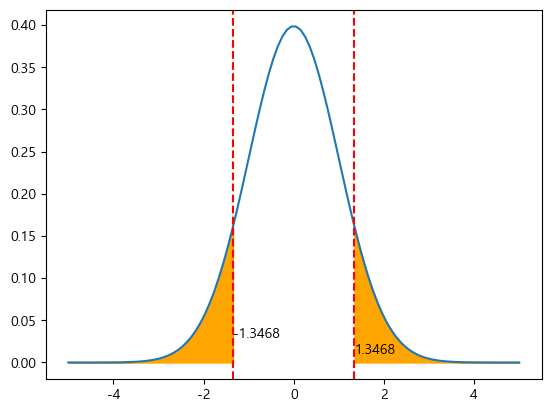

In [20]:
# 표준정규 분포를 이용한 pvalue 도출을 그래프로 설명해봅니다
from scipy.stats import norm
P_true = 0.2114
col = 'isna_{}'.format(4)
P_var = P_true * (1 - P_true)
n_samples = df_basetable[col].sum()
P_missing_true = df_basetable.loc[df_basetable[col], 'failure'].mean()
P_missing_var = P_var / n_samples
P_missing_std = P_missing_var ** 0.5

stat = -abs((P_missing_true - P_true) / P_missing_std)

plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100)))
plt.axvline(stat, color='red', linestyle='--')
plt.text(stat, 0.03, str(stat)[:7])
plt.axvline(-stat, color='red', linestyle='--')
plt.text(-stat, 0.01, str(-stat)[:6])
plt.fill_between(np.linspace(-5, stat, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-5, stat, 100)), color='orange')
plt.fill_between(np.linspace(-stat, 5, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-stat, 5, 100)), color='orange')

plt.show()

## 단계 1-2

measuremenet_3을 포함하여 measurement_4 ~ 16까지 위 검정을 반복하고 

귀무가설을 기각할 수 있는 경우의 p-value의 합을 A라고 한다. (유의 수준은 5%로 한다.)

In [21]:
from scipy.stats import norm
p = 0.2114
mu, sigma2  = p, p * (1 - p)
ztest_list = list()
for i in range(3, 17):
    name = 'isna_{}'.format(i)
    N = df_basetable[name].sum()
    sam_mean_mu, sam_mean_sigma2 = mu, sigma2 / N
    sam_mean = df_basetable.loc[df_basetable[name], 'failure'].pipe(
        lambda x:  x.mean()
    )
    Z = (sam_mean - sam_mean_mu) / (sam_mean_sigma2 ** 0.5)
    Z = -abs(Z)
    ztest_list.append(
        pd.Series([Z, N, norm.cdf(Z) * 2], index = ['stat', 'N', 'pvalue'], name = name)
    )
df_ztest = pd.DataFrame(ztest_list)
df_ztest

,stat,N,pvalue
isna_3,-2.905807,312.0,0.003663
isna_4,-1.346824,442.0,0.178037
isna_5,-2.221383,565.0,0.026325
isna_6,-0.261780,640.0,0.793491
isna_7,-0.890904,766.0,0.372981
isna_8,-0.698051,853.0,0.485145
isna_9,-0.539344,989.0,0.589650
isna_10,-0.762200,1059.0,0.445940
isna_11,-0.103525,1180.0,0.917546
isna_12,-0.609528,1287.0,0.542174


In [22]:
# 귀무가설을 기각할 수 있는 경우의 p-value의 합을 A라고 한다. (유의 수준은 5%로 한다.)
display(df_ztest.query('pvalue < 0.05'))
A = df_ztest.query('pvalue < 0.05')['pvalue'].sum()
A

,stat,N,pvalue
isna_3,-2.905807,312.0,0.003663
isna_5,-2.221383,565.0,0.026325


0.029988079249523434

**Tip** chi2 검정과 목적이 같습니다. chi2  검정으로 풀어 보고 결과를 비교해봅니다.

In [23]:
from scipy.stats import chi2_contingency

df_chi2 = df_basetable[['isna_{}'.format(i) for i in range(3, 17)]].apply( # Apply ~ axis=0을 통해 각 컬럼을 가져옵니다.
    lambda x: chi2_contingency(
        pd.crosstab(index = x, columns = df_basetable['failure'])
    ),  axis = 0
).apply(
    lambda x: pd.Series(x[:2], index = ['chi2_stat', 'chi2_pvalue']) # 4개의 결과값중에서 검정통계량과 pvalue만 취합니다.
)
df_ztest.join(
    df_chi2
)

,stat,N,pvalue,chi2_stat,chi2_pvalue
isna_3,-2.905807,312.0,0.003663,8.172335,0.004253
isna_4,-1.346824,442.0,0.178037,1.690225,0.193571
isna_5,-2.221383,565.0,0.026325,4.825618,0.028040
isna_6,-0.261780,640.0,0.793491,0.045938,0.830288
isna_7,-0.890904,766.0,0.372981,0.738959,0.389995
isna_8,-0.698051,853.0,0.485145,0.451816,0.501474
isna_9,-0.539344,989.0,0.589650,0.259546,0.610432
isna_10,-0.762200,1059.0,0.445940,0.547787,0.459223
isna_11,-0.103525,1180.0,0.917546,0.005323,0.941839
isna_12,-0.609528,1287.0,0.542174,0.348265,0.555097


## 단계 1-3

검정 결과 귀무가설을 기각할 수 있는 경우는 총 두 건이다. 

해당 파생 변수명의 뒷 자리 번호 순으로 na_1, na_2로 파생 변수를 만들어 prob1 데이터셋을 생성하라.

In [24]:
df_prob1 = df_basetable.assign(
    na_1 = lambda x: x['isna_3'],
    na_2 = lambda x: x['isna_5'],
)
df_prob1.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_10,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17,na_1,na_2
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,False,True,False,False,False,False,False
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,False
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,False,True,False,False,False,False,False,False,False,False
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,False
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,False


In [25]:
A, round(A, 3)

(0.029988079249523434, 0.03)

A의 값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오. 

**0.030**

# 문제 2

첫째는 스프링 개발 업체들은 실험이 제품 별로 공정하게 진행이 됐는지를 의문을 가지고 있다.

product_code에 따라 개발 업체가 다르다. 

product_code에 따라서 스프링에 가한 부하(loading)를 동일하게 했는지 조사하라.

둘째는, attribute_0와 attribute_1은 스프링을 구성하는 주요 소재이다. 

failure와는 관계가 없음이 이전에 검증되었다. 

하지만, 이에 대한 재확인 요청을 받아 attribute_0와 attribute_1은 failure와 상관없음을 확인한다.

이를 위해 다음 단계를 수행하라.


## 단계 2-1

prob1에서 입력 변수 loading에 결측이 없는 행들을 뽑아 prob2 데이터프레임을 만든다.

Hint] prob2의 데이터 수는 21,257 이다.


In [26]:
df_prob2 = df_prob1.loc[df_prob1['loading'].notna()]
df_prob2.shape

(21257, 42)

## 단계 2-2

prob2에 loading의 각 행들에 자연 로그 함수를 적용하여 파생 변수 loading_log를 만든다.


In [27]:
df_prob2 = df_prob2.assign(
    loading_log = lambda x: np.log(x['loading'])
)
df_prob2.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,isna_11,isna_12,isna_13,isna_14,isna_15,isna_16,isna_17,na_1,na_2,loading_log
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,False,False,False,True,False,False,False,False,False,4.383276
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,False,False,False,False,False,False,False,False,False,4.441356
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,True,False,False,False,False,False,False,False,False,4.411949
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,False,False,False,False,False,False,False,False,False,4.615813
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,False,False,False,False,False,False,False,False,False,5.236761


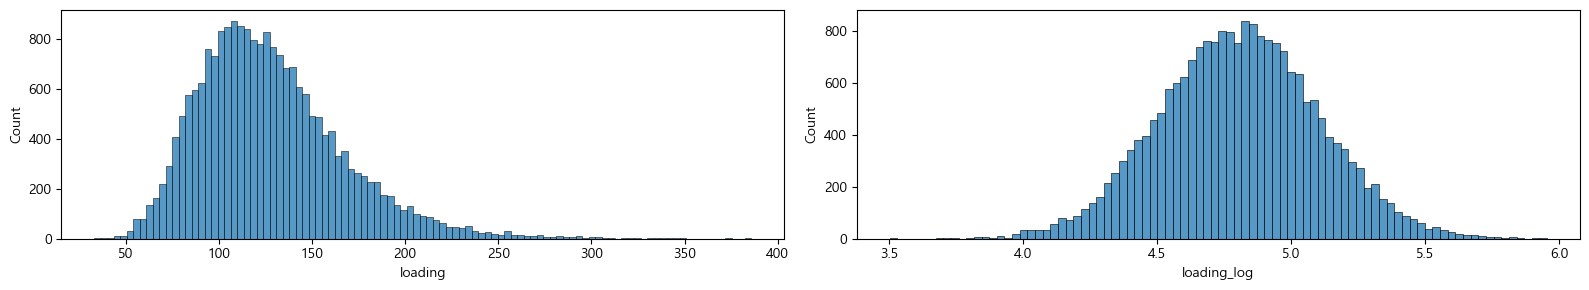

In [28]:
# log 변환 효과를 히스토그램으로 확인합니다. 
_, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_prob2, x = 'loading', ax = axes[0])
sns.histplot(df_prob2, x = 'loading_log', ax = axes[1]) # 좌측으로 치우친 분포가 대칭형 분포에 가깝게 변환됐습니다.
plt.tight_layout()
plt.show()

## 단계 2-3

loading_log가 product_code 각각에 대해서 정규성을 지니고 있는지 확인하고자 한다.

이를 위해 product_code 별로 loading_log에 대한 Jarque-Bera로 검정하고, 

검정 결과 정규성을 부정할 수 없는 경우의 product_code의 수를 B라고 한다.(유의 수준: 5%)

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [29]:
# 방법 1: 하드코딩
from scipy.stats import jarque_bera
B = 3
(
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'A', 'loading_log']),
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'B', 'loading_log']),
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'C', 'loading_log']),
    jarque_bera(df_prob2.loc[df_prob2['product_code'] == 'E', 'loading_log']),
    3
)

(Jarque_beraResult(statistic=1.467731470333654, pvalue=0.4800496537264637),
 Jarque_beraResult(statistic=0.6168837955943998, pvalue=0.7345906322931469),
 Jarque_beraResult(statistic=7.536229242478234, pvalue=0.023095566154546443),
 Jarque_beraResult(statistic=0.04839464502051384, pvalue=0.9760930856160965),
 3)

In [30]:
# 방법 2: groupby ~ apply ~ jarque_bera
from scipy.stats import jarque_bera
df_jarque = df_prob2.groupby('product_code')['loading_log'].apply(
    lambda x: pd.Series(jarque_bera(x), index = ['stat', 'pvalue'])
).unstack(level = -1)
display(df_jarque)
B = (df_jarque['pvalue'] >= 0.05).sum()
B

,stat,pvalue
product_code,,
A,1.467731,0.480050
B,0.616884,0.734591
C,7.536229,0.023096
E,0.048395,0.976093


3

## 단계 2-4

loading_log 변수를 product_code로 구분했을 때, 

등분산성을 보이는지 Bartlett 검정을 통해 확인한다.

검정 결과에서 p-value를 C라고 한다.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [31]:
# 방법 1: 하드코딩
from scipy.stats import bartlett
result_2_4 = bartlett(
    df_prob2.loc[df_prob2['product_code'] == 'A', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'B', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'C', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'E', 'loading_log']
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

In [32]:
# 방법 2: groupby ~ agg ~ list + list unpacking

# list unpacking
def test(*args):
    print(len(args),args)
test('A', 'B', 'C')
test(['A', 'B', 'C'])
test(*['A', 'B', 'C']) # *: list unpacking operator

3 ('A', 'B', 'C')
1 (['A', 'B', 'C'],)
3 ('A', 'B', 'C')


In [33]:
# agg ~ list로 product_code에 따라 loading_log을 하나의 리스트에 모아, product_code 별로 모아진 loading_log들의 리스트를
# list unpacking으로 bartlett 함수에 전달합니다.
result_2_4 =  bartlett(
    *df_prob2.groupby('product_code')['loading_log'].agg(list) # pd.Series는 list unpacking을 지원합니다.
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

## 단계 2-5

product_code에 대한 분산분석(ANOVA)을 통해서 loading_log 평균에 차이가 있는지 검정한다.

그 결과 중 p-value를 D라고 한다.

---

**함수 가이드**

 scipy.stats 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [34]:
from scipy.stats import f_oneway
result_2_5 = f_oneway(
    *df_prob2.groupby('product_code')['loading_log'].agg(list)
)
D = result_2_5.pvalue
D, result_2_5

(0.7733782072320899,
 F_onewayResult(statistic=0.37177284134760413, pvalue=0.7733782072320899))

**Tip** 일원분산분석을 직접해봅니다.

In [35]:
from scipy.stats import f
# H0: 모집단들의 평균은 같다 / H1: 모집단들 평균 같지 않다.
# F = MSR / MSE, dof1 = k - 1, dof2 = N - k,  k: 모집단의 수, N: 표본수 / 우측 꼬리 검정
# MSR = SSR / (k - 1), MSE = SSE / (N - k) : SSR(Sum of squares due to Regression), SSE(Sum of squares Error)
# SSR  = ((y_prd - y_bar) ** 2).sum(), SSE = ((y_true - y_bar) ** 2).sum()
N, k = len(df_prob2), df_prob2['product_code'].nunique()
y_true = df_prob2['loading_log']
y_bar = y_true.mean()
# s_mean = df_prob2.groupby('product_code')['loading_log'].mean()
# y_prd = df_prob2['product_code'].map(s_mean)
y_prd = df_prob2.groupby('product_code')['loading_log'].transform('mean')

# 범주형 변수의 가변수로 OLS(정규방정식)를 통해 만들어진 선형회귀모델의 예측 값은 범주별 target 변수의 평균으로 예측하는 것과 동일합니다.
# ANOVA는 선형회귀모델의 유의미성 검증을 위해 사용하는 분산분석을 범주별 평균이 같다 같지않다를 검증하는 확장하여 활용한 것입니다.
# SST = ((y_true - y_bar) ** 2).sum()
# SST = SSR + SSE  , SST의 자유도(n - 1) = SSR 자유도(k - 1) + SSE 자유도 (n - k) <= 정규 방정식에 의해 풀이된 선형회귀모델
# SST = SSR + SSE <= 정규방정석으로 구한 선형회귀모델 성립
SSR = ((y_prd - y_bar) ** 2).sum()
SSE = ((y_true - y_prd) ** 2).sum()
SST = ((y_true - y_bar) ** 2).sum()
MSR, MSE = SSR / (k - 1), SSE / (N - k)
F = MSR / MSE

SST, SSR + SSE, f.sf(F, k - 1, N - k)

(1879.1520065602526, 1879.1520065602524, 0.7733782072326594)

## 단계 2-6

카이제곱검정을 통해 attribute_0, attribute_1의 결합값이 failure와 연관이 있는지 조사하라. 

attribute_0, attribute_1의 결합값의 의미 attribute_0=material_7, attribute_1=material_8 이라면, 이 둘의 결합값은
matertial_7material_8를 의미한다.

(유의 수준 1%) 연관이 있다면 E값은 1 없으면 0으로 한다.

---

**함수 가이드**

 scipy.stats.chi2_contingency, correction=False
 
 문제 지시사항 외 Default 값 사용
 
---


In [36]:
from scipy.stats import chi2_contingency

result_2_6 = chi2_contingency(
    pd.crosstab(
        index = df_prob2['attribute_0'] + df_prob2['attribute_1'],
        columns = df_prob2['failure']
    ), correction=False
)
pvalue = result_2_6[1]
# H0: 독립 O -> 연관 X -> 0
# H1: 독립 X -> 연관 O -> 1
E = 0 if pvalue >= 0.01 else 1
E, result_2_6

(0,
 (7.0400463075335615,
  0.029598749837407304,
  2,
  array([[4106.03584702, 1102.96415298],
         [4162.79042198, 1118.20957802],
         [8487.17373101, 2279.82626899]])))

**Tip!** $Chi^2$ 검정도 직접해봅니다.

$chi2 = \sum_{i,j}\frac{(E_{ij} - O_{ij})^2}{E_{ij}}$

$p(X=x_i, Y=y_j) = p(X=x_i) p(Y=y_j)$

In [37]:
from scipy.stats import chi2
s_attr01 = df_prob2['attribute_0'] + df_prob2['attribute_1']
df_O = pd.crosstab(
    index = s_attr01, columns = df_prob2['failure']
)
df_E = s_attr01.value_counts().rename('val').to_frame().dot(
    df_prob2['failure'].value_counts(normalize = True).rename('val').to_frame().T
)
Chi2 = ((df_E - df_O) ** 2 / df_E).sum().sum()
dof = (s_attr01.nunique() - 1) * (df_basetable['failure'].nunique() - 1)
Chi2, chi2.sf(Chi2, dof), dof, df_E

(7.040046307533586,
 0.029598749837406936,
 2,
                                 0            1
 material_7material_8  8487.173731  2279.826269
 material_7material_6  4162.790422  1118.209578
 material_5material_5  4106.035847  1102.964153)

In [38]:
B, C, D, E, B + C + D + E, round(B + C + D + E, 2)

(3, 0.5873433093297675, 0.7733782072320899, 0, 4.360721516561858, 4.36)

B + C + D + E의 값을 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하시오.

**4.36**

# 문제 3

로지스틱 회귀모델로 수치형 변수 measurement_0 ~ 17, 

loading과 이진형인 na_1, na_2 중에서 최적의 성능을 보이는 입력 변수들을 찾고자 한다.


## 단계 3-1

prob1을 복사하여 prob3을 만든다. loading의 결측치는 loading의 평균으로 대치한다.  

In [39]:
df_prob3 = df_prob1.assign(
    loading = lambda x: x['loading'].fillna(x['loading'].mean())
)
df_prob3['loading'].isna().sum()

0

## 단계 3-2: 
    
prob3를 80%는 학습데이터 prob3_train으로 20%는 테스트데이터 prob3_test로 나눈다. 

prob3_train의 failure가 1인 비율과 prob3_test의 failure가 1의 비율을 동일하게 한다.


---

**함수 가이드**

 sklearn.model_selection.train_test_split, random_state=123, 
 
 train과 test의 failure의 비율은 stratify 매개 변수를 이용하여 맞춘다.
 
 문제 지시사항 외 Default 값 사용
 
---

In [40]:
from sklearn.model_selection import train_test_split

# train과 test의 failure의 비율은 stratify 매개 변수를 이용하여 맞춥니다.
df_prob3_train, df_prob3_test = train_test_split(
    df_prob3, train_size = 0.8, random_state=123, stratify = df_prob3['failure']
) # stratify 매개 변수를 이용하여 맞춘다.

# train_test_split에서는 reference DataFrame을 반환합니다. 정상적인 데이터 변경작업이 되도록 copy()를 해줍니다.
df_prob3_train, df_prob3_test = df_prob3_train.copy(), df_prob3_test.copy()

In [41]:
# 분리 결괴 확인 루틴입니다.
pd.concat([
    df_prob3_train['failure'].value_counts(normalize = True).rename('train'),
    df_prob3_test['failure'].value_counts(normalize = True).rename('test')
], axis=1)

,train,test
0,0.788535,0.788677
1,0.211465,0.211323


## 단계 3-3

prob3_train의 수치형 입력 변수 loading, measurement_0 ~ 17을 표준화한다. 

prob3_train의 표준화 설정으로 prob3_test의 loading, measurement_0 ~ 17에도 적용한다. 

표준화 처리한 prob3_train과 prob3_test는 문제 4와 문제 5에서 사용한다.


---

**함수 가이드**

 sklearn.preprocessing 제공 기능 활용, 
 
 문제 지시사항 외 Default 값 사용
 
---


In [42]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_std = ['loading'] + ['measurement_{}'.format(i) for i in range(18)]
df_prob3_train[X_std] = std_scaler.fit_transform(df_prob3_train[X_std])
df_prob3_test[X_std] = std_scaler.transform(df_prob3_test[X_std])

## 단계 3-4
    
로지스틱 회귀모델을 사용하여 loading, measurement_0~17과 na_1, na_2를 입력 변수로 하여 prob3_train을 학습한다. 

로지스틱 회귀모델을 prob3_test로 성능을 측정한 값을 A라고 한다.

입력 변수: loading, measurement_0~17, na_1, na_2

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---

**함수 가이드**

 sklearn.linear_model.LogisticRegression, solver='lbfgs', 문제 지시사항 외 Default 값 사용
 
 sklearn.metrics.roc_auc_score
 
---

In [43]:
from sklearn.metrics import roc_auc_score # 성능 지표: AUC
from sklearn.linear_model import LogisticRegression# 로지스틱 회귀모델을 사용

clf_lr = LogisticRegression(solver='lbfgs')
# loading, measurement_0~17, na_1, na_2
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_lr.fit(df_prob3_train[X_lr], df_prob3_train['failure'])
# 로지스틱 회귀모델을 prob3_test로 성능을 측정한 값을 A라고 한다.
A = roc_auc_score(
    df_prob3_test['failure'], clf_lr.predict_proba(df_prob3_test[X_lr])[:, 1]
)
(
    A, roc_auc_score(
        df_prob3_train['failure'],clf_lr.predict_proba(df_prob3_train[X_lr])[:, 1]
    )
)

(0.5792951262053387, 0.5952982435574312)

In [44]:
# 초간단 베이스라인을 만들어봅니다, loading이 클 수록 failure가 True인 가능성이 높아진다라고 생각됩니다.
# 만들어 봅니다.
(
    roc_auc_score(
        df_prob3_test['failure'], df_prob3_test['loading']
    ), 
    roc_auc_score(
        df_prob3_train['failure'], df_prob3_train['loading']
    )
)

(0.5778277926972065, 0.5886355699157924)

In [45]:
# 사전 지식이 없다면, 어떻게 가장 failure를 나타내는 feature를 찾아볼수 있을까요?
from scipy.stats import mannwhitneyu
df_prob3_train[['measurement_{}'.format(i) for i in range(18)] + ['loading']].apply(
    lambda x: mannwhitneyu(
        x.loc[df_prob3_train['failure'] == 0], x.loc[df_prob3_train['failure'] == 1], alternative = 'two-sided'
    ).pvalue
).sort_values(ascending = True).iloc[:5]

loading           1.232029e-60
measurement_17    4.723594e-03
measurement_1     2.660428e-02
measurement_8     5.800023e-02
measurement_6     6.186464e-02
dtype: float64

In [46]:
# LogisticRegression, decision_function에서 Logit
prob = clf_lr.predict_proba(df_prob3_test[X_lr])[:, 1]
np.log(prob / (1 - prob))

array([-1.58696141, -1.62930234, -0.8298201 , ..., -1.53315677,
       -1.40123492, -1.18212665])

In [47]:
clf_lr.decision_function(df_prob3_test[X_lr])

array([-1.58696141, -1.62930234, -0.8298201 , ..., -1.53315677,
       -1.40123492, -1.18212665])

In [48]:
roc_auc_score(
    df_prob3_test['failure'], clf_lr.decision_function(df_prob3_test[X_lr])
)

0.5792951262053387

In [49]:
# ROC AUC의 실제 값을 구해봅니다. 
# score를 기준으로 내림차순 정렬을 합니다,
# Positive 분리점을 아래로 이동시키면서  FPR, TPR을 구합니다. 
# 이를 위해 true/false의 합으로 count를 구하는 것과 cumsum을 
# 이용하여 FP와 TP을 결정 포인트별로 구합니다.
df_prob3_test[['failure']].assign(
    score = clf_lr.decision_function(df_prob3_test[X_lr]) # LogisticRegression의 decision_function은 Logit 출력
).sort_values('score', ascending=False).assign(
    fp=lambda x: (1 - x['failure']).cumsum(), 
    tp=lambda x: (x['failure']).cumsum(),
).assign(
    fpr=lambda x: x['fp'] / (1 - x['failure']).sum(),
    tpr=lambda x: x['tp'] / (x['failure']).sum(),
).head(15)

,failure,score,fp,tp,fpr,tpr
id,,,,,,
15595,0,0.260521,1,0,0.000295,0.000000
11792,0,0.204845,2,0,0.000591,0.000000
14732,0,0.124153,3,0,0.000886,0.000000
11896,0,0.086665,4,0,0.001182,0.000000
4568,1,0.051830,4,1,0.001182,0.001103
13048,1,0.000578,4,2,0.001182,0.002205
10831,1,-0.012503,4,3,0.001182,0.003308
13540,0,-0.029304,5,3,0.001477,0.003308
11248,1,-0.075086,5,4,0.001477,0.004410


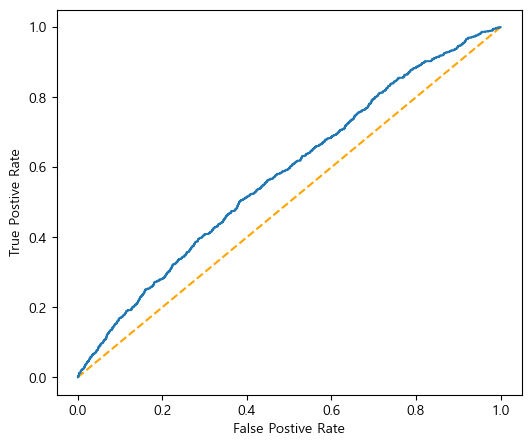

In [50]:
# ROC AUC를 그려봅니다.
# 이 때 logit으로 구해 보겠습니다.
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
df_prob3_test[['failure']].assign(
    score = clf_lr.decision_function(df_prob3_test[X_lr])
).sort_values('score', ascending=False).assign(
    fpr=lambda x: (1-x['failure']).cumsum() / (1 - x['failure']).sum(),
    tpr=lambda x: (x['failure']).cumsum() / ( x['failure']).sum(),
).pipe(
    lambda x: plt.plot(x['fpr'], x['tpr'])
)
plt.gca().set_xlabel('False Postive Rate')
plt.gca().set_ylabel('True Postive Rate')
plt.show()

In [51]:
# ROC AUC의 실제 값을 구해봅니다. 
df_prob3_test[['failure']].assign(
    score = clf_lr.decision_function(df_prob3_test[X_lr])
).sort_values('score', ascending=False).assign(
    fpr=lambda x: (1 - x['failure']).cumsum() / (1 - x['failure']).sum(),
    tpr=lambda x: (x['failure']).cumsum() / ( x['failure']).sum(),
).assign(
    fpr_1 = lambda x: x['fpr'].shift(1).fillna(0) # 곡선아래의 면적을 구하기 위해 곡선을 구성하는 미세사각형의 너비를 구합니다.
).assign(
    sq = lambda x: (x['fpr'] - x['fpr_1']) * x['tpr'] # 각 미세사각형의 면적입니다.
)['sq'].sum() # 0.5792951262053387

0.5792951262053387

## 단계 3-5

loading, measurement_0 ~ 17, na_1, na_2를 후보 입력 변수로 한다. 

전진 선택법을 사용하여 이 후보 입력 변수 중에서 최적의 성능을 보이는 입력 변수의 조합을 찾는다. 

전진 선택법의 선택 기준은 prob3_train을 대상으로 5겹 층화교차검증(5-Fold stratified cross validation)을 하고 

겹외(OOF, Out-Of Fold) 성능의 평균값으로 한다. 전진 선택 과정에서 선택했던 변수를 제외하지 않는다. 

입력 변수: 본 단계 요건 참고

대상 변수: failure 

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

mlxtend.feature_selection.SequentialFeatureSelector

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

문제 지시사항 외 Default 값 사용

---

In [52]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
# loading, measurement_0 ~ 17, na_1, na_2를 후보 입력 변수
X_sfs = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']

sfs = SequentialFeatureSelector(
    estimator = LogisticRegression(solver='lbfgs'),
    forward = True, # 전진 선택법을 사용하여 
    k_features = "best", # 최적의 성능을 보이는 입력 변수의 조합을 찾는다.
    cv = StratifiedKFold(5, random_state=123, shuffle=True), # 5겹 층화교차검증(5-Fold stratified cross validation)
    floating = False, # 전진 선택 과정에서 선택했던 변수를 제외하지 않는다.
    scoring = 'roc_auc', # 성능 지표: AUC(area under of ROC curve), _score 끝나면, _score 빼고,  _error 끝나면, neg_ 앞에 붙인다, neg_mean_squared_error
# 겹외(OOF, Out-Of Fold) 성능의 평균값으로 한다. 업계 표준, mlxtend 업계 표준 따름
)
sfs.fit(df_prob3_train[X_sfs], df_prob3_train['failure'])

c:\users\강선구\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


SequentialFeatureSelector(clone_estimator=True,
                          cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='warn',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, 

In [53]:
X_sfs_best = list(sfs.k_feature_names_)
X_sfs_best, sfs.k_score_# , sfs.subsets_

(['loading',
  'measurement_1',
  'measurement_4',
  'measurement_14',
  'measurement_17',
  'na_1'],
 0.5917537024093409)

## 단계 3-6

단계 3-5에서 찾은 최적의 입력 변수 조합으로 로지스틱 회귀모델을 사용하여 prob3_train을 학습하고 

prob3_test로 성능을 측정한 값을 B라고 한다.

입력 변수: **단계 3-5**에서 도출한 최적의 입력 변수 조합

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수 가이드**

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

문제 지시사항 외 Default 값 사용

---

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score # 성능 지표: AUC

X_lr = X_sfs_best
clf_lr = LogisticRegression(solver='lbfgs')
clf_lr.fit(df_prob3_train[X_lr], df_prob3_train['failure'])
B = roc_auc_score(df_prob3_test['failure'], clf_lr.predict_proba(df_prob3_test[X_lr])[:, 1])
(
    B,
    roc_auc_score(df_prob3_train['failure'], clf_lr.predict_proba(df_prob3_train[X_lr])[:, 1])
)

(0.5838326230092876, 0.5936682060775388)

In [55]:
A, B, A - B, round(A - B, 3)

(0.5792951262053387, 0.5838326230092876, -0.004537496803948882, -0.005)

In [56]:
roc_auc_score(
    df_prob3_test['failure'], df_prob3_test['loading']
)

0.5778277926972065

A-B값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오

**-0.005**

# 문제 4

차원 축소 기법을 통한 데이터의 특성과 failure 분류 성능을 높힐 만한 요소를 살펴 본다. 

첫째로, loading을 제외하고, measurement_0 ~ 17을 입력으로 failure를 대상 변수로 Linear Discrimant Analysis(LDA) 모델을 만든다. 

True/False 이진 변수인 failure를 분류한다는 점에서 LDA 모델은 measurement_0 ~ 17를 한 개의 경계점으로 

failure를 최대한 정확하게 구분하도록 하나의 연속형 변수로 변환한다. 

스프링의 내구력이 높을 수록 failure 확률이 낮아진다면, 

측정값 measurement_0 ~ 17의 LDA 변환값은 스프링의 내구력을 나타낸다라고 할 수 있다.

실험에서 스프링에 가한 부하(loading)와  LDA 변환값의 상관도를 측정하여, 

측정값 measurement_0~17 에서 예상되는 내구력이 스프링에 따라 부하(loading)의 반영 정도를 가늠한다.

둘째로, PCA를 사용하여 차원 감소로 failure 분류 성능에 얼마나 효과가 있을지 살펴본다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.


## 단계 4-1

prob3_train에서 measurement_0 ~ 17을 입력으로 failure를 대상 변수로 하여 LDA(Linear Discriminant Analysis) 모델을 학습한다. 

measurement_0 ~ 17에 대한 prob3_train에서의 LDA의 변환값과 loading과 스피어만 상관도 (spearman correlation)의 p-value를 구하여 A라고 한다.

입력 변수] measurement_0 ~ 17 (순서에 유의 하시오)

대상 변수] failure

---
**함수가이드**

sklearn.discriminant_analysis 제공 기능 활용

scipy.stats.spearmanr

문제 지시사항 외 Default 값 사용

---

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA(Linear Discriminant Analysis) 모델을 학습한다
from scipy.stats import spearmanr
X_lda = ['measurement_{}'.format(i) for i in range(18)] # measurement_0 ~ 17을 입력으로 failure를 대상 변수
# LDA의 변환값과 loading과 스피어만 상관도 (spearman correlation)의 p-value를 구하여 A
lda = LinearDiscriminantAnalysis()
lda.fit(df_prob3_train[X_lda], df_prob3_train['failure'])
result_4_1 = spearmanr(df_prob3_train['loading'], lda.transform(df_prob3_train[X_lda]))
A = result_4_1.pvalue
A, result_4_1

(0.6995009550811424,
 SpearmanrResult(correlation=0.0029462997112993335, pvalue=0.6995009550811424))

**Tip** Histogram을 통해 lda 변환값의 유의미성을 살펴봅니다.

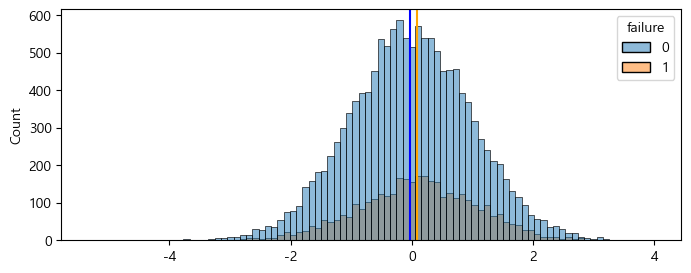

In [58]:
# failure별 LDA의 히스토그램을 그려봅니다.
plt.figure(figsize=(8, 3))
l = lda.transform(df_prob3_train[X_lda])
sns.histplot(x=l[:, 0], hue=df_prob3_train['failure'])
plt.axvline(l[df_prob3_train['failure'] == 0].mean(), color='blue')
plt.axvline(l[df_prob3_train['failure'] == 1].mean(), color='orange')
plt.show()

**Q**: 시각화를 통해서는 failure와의 관련성을 LDA 변환값의 의미를 보기는 힘이 듭니다. 

이 때 둘 간의 연관성을 확인하는 방법을 생각해본다면 어떤 방법을 사용해볼 수 있을 까요?

In [59]:
# Answer: T-검정을 사용해볼만 합니다. 
from scipy.stats import ttest_ind, bartlett

lda_value = lda.transform(df_prob3_train[X_lda])[:, 0]
lda_true = lda_value[df_prob3_train['failure'] == 1]
lda_false = lda_value[df_prob3_train['failure'] == 0]

equal_var = 1 if bartlett(lda_true, lda_false).pvalue >= 0.05 else 0
ttest_ind(lda_true, lda_false, equal_var=equal_var)

Ttest_indResult(statistic=5.927378456131373, pvalue=3.1370243739954236e-09)

In [60]:
# 비모수 방법인 mannwhiteny 또한 사용해볼만 하겠지요
from scipy.stats import mannwhitneyu

lda_value = lda.transform(df_prob3_train[X_lda])[:, 0]
mannwhitneyu(
    lda_value[df_prob3_train['failure'] == 1],
    lda_value[df_prob3_train['failure'] == 0]
)

MannwhitneyuResult(statistic=22895846.0, pvalue=1.4282689236218276e-10)

## 단계 4-2

prob3_train에서 measurement_0 ~ 17을 대상으로 주성분분석(Principal Component Analysis, PCA) 모델을 학습한다. 

분산 설명율이 높은 순으로 주성분을 변수명을 pca_0 ~ 17하여 prob3_train에 추가하여 prob4_train을 만든다. 

prob3_test에 prob3_train를 학습했던 PCA 모델로 동일한 방법으로 pca_0 ~17 파생 변수를 추가하여 prob4_test를 만든다.

입력 변수] measurement_0 ~ 17 (순서에 유의 하시오)

---
**함수가이드**

sklearn.decomposition.PCA, random_state=123

문제 지시사항 외 Default 값 사용

---


In [61]:
from sklearn.decomposition import PCA # 주성분분석(Principal Component Analysis, PCA) 모델을 학습한다.
X_pca = ['measurement_{}'.format(i) for i in range(18)] # measurement_0 ~ 17을 대상


# 분산 설명율이 높은 순으로 주성분을 변수명을 pca_0 ~ 17하여 prob3_train에 추가하여 prob4_train을 만든다.
X_comp = ['pca_{}'.format(i) for i in range(18)]
# prob3_test에 prob3_train를 학습했던 PCA 모델로 동일한 방법으로 pca_0 ~17 파생 변수를 추가하여 prob4_test를 만든다.
pca = PCA(n_components = None, random_state=123)
pca.fit(df_prob3_train[X_pca])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=123,
    svd_solver='auto', tol=0.0, whiten=False)

In [62]:
df_prob4_train = df_prob3_train.copy()
# 2차원 numpy array를 직접 대입을 시킬 수는 없고,
# DataFrame으로 만들어야 합니다. 이 때, index를 지정을 하여 위치에 맞게 대입되도록 합니다.
df_prob4_train[X_comp] = pd.DataFrame(pca.transform(df_prob3_train[X_pca]), index = df_prob3_train.index)
df_prob4_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17
id,,,,,,,,,,,,,,,,,,,,,
12186,C,-0.577100,material_7,material_8,5,8,-1.014834,0.988654,0.608313,-1.219573,...,0.069564,-1.216006,-1.461594,1.366461,-0.286995,-0.736695,0.116673,0.194459,0.163881,-0.465342
7532,B,1.853148,material_5,material_5,8,8,-1.250324,-0.929650,0.912362,-1.220579,...,-0.125304,-1.003035,-0.529226,-1.036229,-0.147873,-0.587166,1.516481,0.656874,-1.360975,-0.366738
5469,B,0.509210,material_5,material_5,8,8,-0.779343,0.748866,1.824512,-1.582543,...,1.274128,-1.260589,0.142090,0.689487,1.260814,0.150481,-1.411919,0.530856,0.642580,-1.134623
5998,B,0.082142,material_5,material_5,8,8,-1.485815,-0.210286,0.000213,-0.999378,...,0.516806,-0.783940,0.199165,2.100699,0.046940,0.309664,0.277571,1.093004,-1.001688,-0.209835
21825,E,-0.570930,material_7,material_6,6,9,-1.014834,0.988654,-0.607887,-0.353874,...,-1.305984,0.337364,-2.846921,-0.310261,0.439548,1.036061,-3.057189,0.604486,-0.059815,-1.033242


In [63]:
# DataFrame을 구성시켜놓고 join을 통해 결합시켜줍니다.
df_prob4_test = df_prob3_test.join(
    pd.DataFrame(
        pca.transform(df_prob3_test[X_pca]), index = df_prob3_test.index, columns = X_comp
    )
)
df_prob4_test.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17
id,,,,,,,,,,,,,,,,,,,,,
6626,B,-0.646778,material_5,material_5,8,8,-0.779343,-0.210286,0.912362,0.694817,...,-0.435347,-2.451195,-0.212859,-0.474401,-0.152049,0.415381,-0.211874,1.251870,-0.318274,-0.142292
6302,B,-0.776364,material_5,material_5,8,8,-0.308363,0.509078,1.216412,-1.793689,...,0.600191,-1.158239,-1.832178,-1.066241,-1.273782,0.121801,1.330900,-0.396394,0.157529,-0.862240
2068,A,1.220389,material_7,material_8,9,5,1.104580,-1.409226,-0.911937,0.082494,...,0.442147,-1.731923,-0.481832,0.195241,0.004504,-0.244213,-2.249243,0.099636,-0.293499,-0.412578
4661,A,0.213270,material_7,material_8,9,5,-0.072872,-1.169438,-0.607887,0.287607,...,1.318845,-0.761127,1.713534,-1.731517,1.039950,-2.236054,0.923431,-1.178613,-1.247759,0.304439
10303,B,0.694332,material_5,material_5,8,8,-0.072872,-0.689862,0.304263,1.477063,...,0.507550,0.996317,1.105341,-0.423133,1.067850,0.665243,-1.121216,0.637357,-0.238106,0.043725


In [64]:
# 분산 설명력, 공분산 행렬의 고윳값(고윳값 분해를 통해 도출)
pca.explained_variance_

array([1.85613793, 1.41894459, 1.25547315, 1.1632852 , 1.06637856,
       1.05000212, 1.01995967, 1.00922255, 1.00657757, 0.99213623,
       0.98552903, 0.97614082, 0.97170312, 0.87532548, 0.81399432,
       0.70771288, 0.67969009, 0.15283534])

In [65]:
# df_prob3_train[X_pca].cov()
# 공분산행렬을 고윳값 분해를 해봅니다.
# 평균중심화(mean centering)후 행렬곱을 이용해 공분산 행렬을 구합니다.
df_corr = (df_prob3_train[X_pca] - df_prob3_train[X_pca].mean()).pipe(
    lambda x: x.T.dot(x) / (len(x) - 1)
)
ev, emat = np.linalg.eigh(df_corr)
ev[np.argsort(-ev)]

array([1.85613793, 1.41894459, 1.25547315, 1.1632852 , 1.06637856,
       1.05000212, 1.01995967, 1.00922255, 1.00657757, 0.99213623,
       0.98552903, 0.97614082, 0.97170312, 0.87532548, 0.81399432,
       0.70771288, 0.67969009, 0.15283534])

In [66]:
df_emat_t = pd.DataFrame(
    pca.components_, index = ['evec{}'.format(i + 1) for i in range(18)], columns = X_pca # : emat.T
)
df_emat_t

,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
evec1,0.022883,-0.019582,-0.015097,0.050394,0.204060,0.371117,0.190529,0.268949,0.427064,0.164705,-0.009905,-0.022599,0.002799,-0.033895,0.011526,-0.020182,-0.027936,0.704078
evec2,0.526517,-0.562470,-0.103690,0.016855,-0.042447,0.036740,0.000815,0.021352,-0.059520,-0.001804,0.008022,0.245695,0.380476,-0.144570,-0.113087,-0.383713,0.039553,-0.023152
evec3,-0.186391,0.074810,0.142814,0.003889,0.052836,0.007751,0.029356,-0.016607,0.031873,-0.022902,-0.092871,0.365114,0.286045,0.298758,-0.396739,0.170772,0.657852,0.037097
evec4,-0.352613,0.330151,-0.080426,0.003231,0.040330,0.037848,-0.021599,-0.027172,-0.029152,-0.004636,-0.226711,0.441333,0.147128,-0.533183,-0.214552,-0.283855,-0.276158,-0.008819
evec5,0.029019,-0.105361,0.113744,-0.060397,0.193537,0.099383,-0.088444,-0.137312,-0.036919,-0.053795,-0.701265,0.072859,0.144512,-0.047744,0.574674,0.181507,0.098694,-0.004914
evec6,-0.267111,-0.062494,0.659857,0.210428,-0.196963,0.108322,0.070451,0.241535,-0.197077,-0.001331,-0.023974,-0.133090,0.220977,0.233257,0.092792,-0.366759,-0.166527,0.001644
evec7,0.001058,0.109837,-0.244030,0.502298,0.536801,0.234953,-0.118318,-0.203609,-0.392317,0.188402,0.032372,-0.152960,0.055700,0.181920,-0.067272,-0.150071,-0.000610,-0.013044
evec8,-0.060505,-0.035790,0.260950,-0.337998,0.205978,0.106405,-0.653943,-0.359636,0.323277,0.090250,0.186578,-0.080167,0.112818,0.056335,-0.060983,-0.148092,-0.080532,0.007988
evec9,0.007082,-0.042138,0.110591,-0.228984,0.021452,0.611846,0.240576,-0.283762,-0.246375,-0.536676,0.204646,0.066616,-0.114173,-0.072068,-0.023062,0.079159,-0.010229,0.011159
evec10,-0.007179,0.036969,-0.168208,0.280662,0.000296,0.046954,-0.516073,0.477417,0.085181,-0.613134,0.039458,0.018145,0.049231,-0.002254,0.053170,0.062424,0.028366,0.004659


In [67]:
# Q:첫번째 주성분에서 영향이 가장 높은 변수?
df_emat_t.loc['evec1'].abs().idxmax()

'measurement_17'

In [68]:
# 제1주성분을 직접 구해봅니다: (X - X_mean).dot(제1주성분 고유벡터) 
# 그리고 pca transform으로 나온 결과와 비교합니다.
pd.concat([
    (df_prob3_train[X_pca] - df_prob3_train[X_pca].mean()).dot(
        df_emat_t.loc['evec1']
    ).rename('pca_0_direct'),
    df_prob4_train['pca_0']
], axis=1)

,pca_0_direct,pca_0
id,,
12186,2.960512,2.960512
7532,-1.798466,-1.798466
5469,1.729983,1.729983
5998,1.228829,1.228829
21825,0.642582,0.642582
...,...,...
3875,-1.246430,-1.246430
21866,-2.244429,-2.244429
22966,0.686323,0.686323


In [69]:
# 역변환: PCA 원래의 값으로 변환도 가능합니다.
# PCA 주성분들과 eigen matrix의 역행렬(components_)와 행렬곱으로 구할 수 있습니다.
pd.concat([
    (
        df_prob4_train[X_comp].dot(df_emat_t['measurement_0'].values) + 
        df_prob3_train['measurement_0'].mean()
    ).rename('measurement_0_inv'),
    df_prob3_train['measurement_0']
], axis = 1)

,measurement_0_inv,measurement_0
id,,
12186,-1.014834,-1.014834
7532,-1.250324,-1.250324
5469,-0.779343,-0.779343
5998,-1.485815,-1.485815
21825,-1.014834,-1.014834
...,...,...
3875,-1.485815,-1.485815
21866,-0.072872,-0.072872
22966,-0.308363,-0.308363


In [70]:
# 참고 pca.inverse_transform를 통해 PCA의 역변환을 할 수 있습니다. 이를 통해 원래 변수로 변환할 수 있습니다.
# 복원하면 차원축소 과정에서 제외된 성분이지닌 변동성을 잃어버리게 됩니다.
total_var = df_prob4_train[X_pca].var().sum()
print("Var: {}".format(total_var))
for i in range(18, 0, -1):
    pca_exp = PCA(n_components=i, random_state=123)
    pca_exp.fit(df_prob3_train[X_pca])
    X_tr = pca_exp.transform(df_prob4_train[X_pca])
    print(
        i, total_var - pca_exp.explained_variance_.sum(),
        (pca_exp.inverse_transform(X_tr) - df_prob4_train[X_pca]).var().sum()
    )

Var: 18.001048645499374
18 -1.7763568394002505e-13 3.321000123346255e-29
17 0.1528353405813867 0.15283534058156667
16 0.8325254315599828 0.8325254315601602
15 1.540238311500751 1.5402383115009304
14 2.354232634771007 2.3542326347711935
13 3.2295581105971323 3.229558110597323
12 4.201261233029383 4.201261233029561
11 5.177402050676582 5.177402050676782
10 6.162931078706906 6.162931078707109
9 7.155067310617852 7.155067310618056
8 8.161644880948511 8.161644880948696
7 9.170867563764428 9.170867450007895
6 10.196212406010272 10.194751529554644
5 11.248118119364571 11.246233554318538
4 12.323356201212572 12.319799559755685
3 13.490453056974228 13.484471574782999
2 14.730648352824165 14.728978248312687
1 16.144917156453445 16.144913730254192


## 단계 4-3

초기에 loading을 입력 변수로 하여 prob4_train을 학습하고, prob4_test에 대한 성능을 측정한다.

여기에 pca_0에서 pca_17까지 입력 변수를 하나씩 추가 하면서, 

즉 분산 설명율이 높은 순으로 컴포넌트를 하나씩 추가하여 prob4_train를 학습하고 prob4_test의 성능을 측정 했을 때, 

최적의 성능을 보인 컴포넌트들의 분산 설명율의 합을 B라고 한다. (만일 없다면 B = 0이다.)

입력 변수: 설명 참고

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

sklearn.linear_model.LogisticRegression, solver=’lbfgs’

---

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_lr = list()
X_lr_hist = list()
auc_test, auc_train = list(), list()
for i in ['loading'] + X_comp:
    clf_lr = LogisticRegression(solver='lbfgs')
    X_lr.append(i)
    clf_lr.fit(df_prob4_train[X_lr], df_prob4_train['failure'])
    auc_test.append(
        roc_auc_score(df_prob4_test['failure'], clf_lr.predict_proba(df_prob4_test[X_lr])[:, 1])
    )
    auc_train.append(
        roc_auc_score(df_prob4_train['failure'], clf_lr.predict_proba(df_prob4_train[X_lr])[:, 1])
    )
    X_lr_hist.append(X_lr.copy())
    print(i, auc_test[-1], auc_train[-1])

loading 0.5778277926972065 0.5886355699157924
pca_0 0.579565141627812 0.5902607636650189
pca_1 0.5784170060859327 0.5906173884232395
pca_2 0.5786498903164131 0.5906803365700851
pca_3 0.5801256923420173 0.5911363799178113
pca_4 0.5805735466314028 0.5912654510937876
pca_5 0.5811103203542446 0.5914601161518473
pca_6 0.581757510516433 0.5929702204182378
pca_7 0.5808025223153578 0.5934465748718649
pca_8 0.5801787834323228 0.5935233418973748
pca_9 0.5801664063683251 0.593551407042703
pca_10 0.5794231311040503 0.5937232780741002
pca_11 0.5785678108393766 0.5940223479149978
pca_12 0.5782202759108135 0.594022551433093
pca_13 0.5782310244137587 0.593998210668907
pca_14 0.5776818736269195 0.5938648656129314
pca_15 0.5772988360674158 0.5941303346163114
pca_16 0.5768773644670778 0.5941881134035389
pca_17 0.5771252314592396 0.5945461424366163


In [72]:
X_lr_hist[np.argmax(auc_test)], pca.explained_variance_ratio_[: 7]

(['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6'],
 array([0.10311277, 0.07882566, 0.06974445, 0.06462319, 0.0592398 ,
        0.05833005, 0.05666113]))

In [73]:
B =  pca.explained_variance_ratio_[: 7].sum()
B

0.49053704530610653

In [74]:
A, B, A + B, round(A + B, 2)

(0.6995009550811424, 0.49053704530610653, 1.1900380003872488, 1.19)

A + B를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.

**1.19**

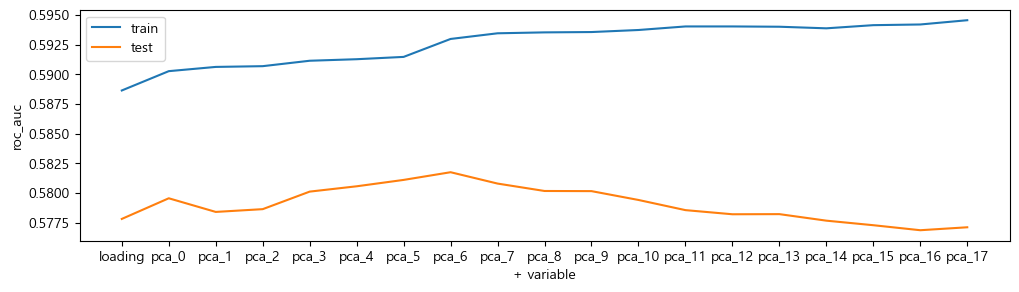

In [75]:
# 전진 선택 단계에 따른 train / test의 성능 변화를 보입니다.
plt.figure(figsize=(12, 3))
sns.lineplot(x = ['loading'] + ['pca_{}'.format(i) for i in range(18)], y = auc_train, label='train')
sns.lineplot(x = ['loading'] + ['pca_{}'.format(i) for i in range(18)], y = auc_test, label='test')
plt.gca().set_xlabel('+ variable')
plt.gca().set_ylabel('roc_auc')
plt.show()

# 문제 5

랜덤포레스트 분류기(Random-Forest Classifier)의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색하고자 한다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.

## 단계 5-1

sklearn에서 제공하는 랜덤포레스트 분류기(Random-Forest Classifier)의 하이퍼 파라미터 중 

n_estimators, max_depth 그리고 min_samples_split의 최적 조합을 탐색한다. 

탐색 값은 아래에 제공한 하이퍼 파라미터의 모든 조합이다. 

prob3_train을 대상으로 5-겹 층화교차검증(5-fold stratified cross validation)으로 

각각  겹외셋(OOF set, Out-Of-Fold set)의 성능에 대한 평균을 기준으로 하이퍼 파라미터를 선택한다.

  - n_estimators: [5, 10, 15]

  - max_depth: [5, 6, 7]
  
  - min_samples_split: [256, 512]

Hint] 모든 하이퍼 파라미터의 조합의 수는 18개이다

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

itertools.product 필요시 사용

sklearn.model_selection.cross_val_score 필요시 사용

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

sklearn.model_selection.GridSearchCV 필요시 사용

---

In [76]:
# 방법1: 쉬운 길: GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV 

gs = GridSearchCV(
    estimator = RandomForestClassifier(random_state=123), # sklearn에서 제공하는 랜덤포레스트 분류기(Random-Forest Classifier)
    param_grid = {
        'n_estimators': [5, 10, 15], # n_estimators: [5, 10, 15]
        'max_depth': [5, 6, 7], # max_depth: [5, 6, 7]
        'min_samples_split': [256, 512] # min_samples_split: [256, 512]
    },
    cv = StratifiedKFold(5, random_state=123, shuffle=True), # 5-겹 층화교차검증(5-fold stratified cross validation)으로
    iid = False, # 각각 겹외셋(OOF set, Out-Of-Fold set)의 성능에 대한 평균
    scoring = 'roc_auc' # AUC (area under of ROC curve)
)
X_gs = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
gs.fit(df_prob3_train[X_gs], df_prob3_train['failure'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=

In [77]:
best_params = gs.best_params_
best_params, gs.best_score_# , gs.cv_results_

({'max_depth': 7, 'min_samples_split': 512, 'n_estimators': 15},
 0.5745226991354744)

In [78]:
# 방법2: 어려운 길
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from itertools import product
params_list = list()
"""
for n_estimators in [5, 10, 15]:
    for max_depth in [5, 6, 7]:
        for min_samples_split in [256, 512]:
            params_list.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split
            })
"""
params_list = [{
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split
} for n_estimators, max_depth, min_samples_split in  product([5, 10, 15], [5, 6, 7], [256, 512])]
scores = list()
X_gs = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
skf = StratifiedKFold(5, random_state = 123, shuffle = True)
for params in params_list:
    """
    cv_scores = cross_val_score(
        RandomForestClassifier(**params, random_state = 123), df_prob3_train[X_gs], df_prob3_train['failure'],
        scoring = 'roc_auc', cv = skf,
    )
    """
    cv_scores = list()
    clf_rf = RandomForestClassifier(**params, random_state = 123)
    for train_idx, valid_idx in skf.split(df_prob3_train[X_gs], df_prob3_train['failure']):
        df_cv_train, df_valid = df_prob3_train.iloc[train_idx], df_prob3_train.iloc[valid_idx]
        clf_rf.fit(df_cv_train[X_gs], df_cv_train['failure'])
        cv_scores.append(
            roc_auc_score(df_valid['failure'], clf_rf.predict_proba(df_valid[X_gs])[:, 1])
        )
    scores.append(np.mean(cv_scores))
    print(params, scores[-1])

{'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 256} 0.5547115468443294
{'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 512} 0.5617150416141751
{'n_estimators': 5, 'max_depth': 6, 'min_samples_split': 256} 0.5568999583940097
{'n_estimators': 5, 'max_depth': 6, 'min_samples_split': 512} 0.5623239919998733
{'n_estimators': 5, 'max_depth': 7, 'min_samples_split': 256} 0.5567633668997499
{'n_estimators': 5, 'max_depth': 7, 'min_samples_split': 512} 0.5642015275666604
{'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 256} 0.5654552370913933
{'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 512} 0.5707474621000601
{'n_estimators': 10, 'max_depth': 6, 'min_samples_split': 256} 0.5681316681217556
{'n_estimators': 10, 'max_depth': 6, 'min_samples_split': 512} 0.5680847464819798
{'n_estimators': 10, 'max_depth': 7, 'min_samples_split': 256} 0.5670255107788329
{'n_estimators': 10, 'max_depth': 7, 'min_samples_split': 512} 0.5724060304780464
{'n_estimators': 15, '

In [79]:
best_params = params_list[np.argmax(scores)]
best_params, np.max(scores) # {'max_depth': 7, 'min_samples_split': 512, 'n_estimators': 15}, 0.5745226991354744

({'n_estimators': 15, 'max_depth': 7, 'min_samples_split': 512},
 0.5745226991354744)

In [80]:
roc_auc_score(
    df_prob3_test['failure'], df_prob3_test['loading']
)

0.5778277926972065

## 단계 5-2

단계 5-1에서 구한 최적 하이퍼 파라미터로 설정한 랜덤포레스트 분류기(Random-Forest Classifier)를 사용하여 prob3_train 학습하고, 

prob3_test로 성능을 측정하여 이 값을 A라고 한다.

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

---


In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_gs = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_rf = RandomForestClassifier(**best_params, random_state=123)
clf_rf.fit(df_prob3_train[X_gs], df_prob3_train['failure'])
A = roc_auc_score(
    df_prob3_test['failure'], clf_rf.predict_proba(df_prob3_test[X_gs])[:, 1]
)
(
    A,
    roc_auc_score(
        df_prob3_train['failure'], clf_rf.predict_proba(df_prob3_train[X_gs])[:, 1]
    )
)

(0.5687712018291998, 0.6416568062149542)

In [82]:
A, round(A, 3)

(0.5687712018291998, 0.569)

A값을 소수점 넷째 자리에서 반올림하여 3째 자리까지 출력하시오.

**0.569**

**Tip** 교차 검점 과정에서 SMOTE Oversampling (sampling_strategy = 'minority')을 적용해봅니다.

지표는 f1_score를 사용합니다.

In [83]:
df_prob3_train['failure'].value_counts(normalize = True)

0    0.788535
1    0.211465
Name: failure, dtype: float64

In [87]:
# 어려운 길 + SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE
params_list = list()
"""
for n_estimators in [5, 10, 15]:
    for max_depth in [5, 6, 7]:
        for min_samples_split in [256, 512]:
            params_list.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split
            })
"""
params_list = [{
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split
} for n_estimators, max_depth, min_samples_split in  product([5, 10, 15], [5, 6, 7], [256, 512])]
scores, scores_smote = list(), list()
X_gs = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
skf = StratifiedKFold(5, random_state = 123, shuffle = True)
for params in params_list[:1]: # 처음 하나의 케이스만 합니다.
    """
    cv_scores = cross_val_score(
        RandomForestClassifier(**params, random_state = 123), df_prob3_train[X_gs], df_prob3_train['failure'],
        scoring = 'roc_auc', cv = skf,
    )
    """
    cv_scores, cv_scores_smote = list(), list()
    clf_rf = RandomForestClassifier(**params, random_state = 123)
    for train_idx, valid_idx in skf.split(df_prob3_train[X_gs], df_prob3_train['failure']):
        df_cv_train, df_valid = df_prob3_train.iloc[train_idx], df_prob3_train.iloc[valid_idx]
        clf_rf.fit(df_cv_train[X_gs], df_cv_train['failure'])
        cv_scores.append(
            f1_score(df_valid['failure'], clf_rf.predict(df_valid[X_gs]))
        )
        smote = SMOTE(sampling_strategy = 'minority') # SMOTE Over-sampler를 설정합니다. 
        X_smote, y_smote = smote.fit_resample(df_cv_train[X_gs], df_cv_train['failure']) # Over-sampling을 수행합니다. 
        # 사용성을 높이기 위해 DataFrame으로 재구성합니다.
        df_cv_train_smote = pd.DataFrame(X_smote, columns = X_gs)
        print(pd.Series(y_smote).value_counts())
        clf_rf.fit(df_cv_train_smote[X_gs], y_smote)
        cv_scores_smote.append(
            f1_score(df_valid['failure'], clf_rf.predict(df_valid[X_gs]))
        )
    scores.append(np.mean(cv_scores))
    scores_smote.append(np.mean(cv_scores_smote))
    print(params, scores[-1], scores_smote[-1])

1    10828
0    10828
dtype: int64
1    10829
0    10829
dtype: int64


c:\users\강선구\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1    10829
0    10829
dtype: int64


c:\users\강선구\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1    10829
0    10829
dtype: int64
1    10829
0    10829
dtype: int64
{'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 256} 0.0005471956224350205 0.32110878515215246
